# Preliminaries + Installs

These instructions are for Python 3.10
### Install Ollama
* `cd /tmp`
* `curl -fsSL https://ollama.com/install.sh | sh`
* Test, Optional (2GB download): `ollama run llama3.2`, Type `/bye` when done
### Install Langchain
* `python3.10 -m pip install langchain langchain_community langchain_chroma langchain_ollama llama-index-legacy pypdf langchain-unstructured "unstructured[pdf]" --user`
### Install SQLite ( >= 3.35.0 required, This will install 3.46 )
* `sudo apt install libreadline-dev python3.10-dev`
* `wget https://sqlite.org/2024/sqlite-autoconf-3460100.tar.gz`
* `tar -xvf sqlite-autoconf-3460100.tar.gz && cd sqlite-autoconf-3460100`
* `./configure`
* `make`
* `sudo make install`
* `python3.10 -m pip uninstall pysqlite3`
* `python3.10 -m pip install pysqlite3-binary --user`

# Build/Expand Document Database + Embeddings

## State

In [1]:
from os import environ, path
import time, sys, json
now = time.time

environ["_RAG_STATE_PATH"] = "data/state.json"

RAGstate = {
    'libDocs' : list(),
    'pages'   : dict(),
}

def save_state():
    global RAGstate
    with open( environ["_RAG_STATE_PATH"], 'w' ) as f:
        json.dump( RAGstate, f, indent = 4 )

def load_state():
    global RAGstate
    try:
        with open( environ["_RAG_STATE_PATH"], 'r' ) as f:
            RAGstate = json.load(f)
    except FileNotFoundError as e:
        print( f"Could not load {environ['_RAG_STATE_PATH']}!\n{e}" )

load_state()

## Helper Functions

In [2]:
from uuid import uuid4

def safe_str( data ):
    """Filters out invalid UTF-8 characters from a string."""
    return str( data ).encode( 'utf-8', 'ignore' ).decode( 'utf-8' )

def gen_ID():
    """ Generate a unique ID """
    return safe_str( uuid4() )

def pull_ollama_model( modelStr ):
    """ Pull a named model from Ollama and store it wherever """
    print( f"About to save '{modelStr}'.\nThis will spew a lot of text on the first run..." )
    os.system( f"ollama pull {modelStr}" )



## Copy PDFs

In [3]:
from os import path, makedirs
from aa_scrape_PDF import copy_pdfs

environ["_RAG_PDF_SOURCE"] = "/media/james/FILEPILE/$_Robust_Planning/Literature/References/storage"
environ["_RAG_PDF_DESTIN"] = "data/input/pdf"
environ["_RAG_PAGE_DESTN"] = "data/input/pages"
environ["_RAG_VERBOSE"]    =    ""
environ["_RAG_DOC_ADD"]    =  "50"
environ["_RAG_DOC_LIMIT"]  = "250"
environ["_RAG_DOC_DBASE"]  = "lit_pdf"
environ["_RAG_VEC_DBASE"]  = "lit_vec"


## Determine if more docs will be loaded this session

In [17]:
__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop( 'pysqlite3' )
import chromadb
from langchain_chroma import Chroma


persistent_client = chromadb.PersistentClient()
collection        = persistent_client.get_or_create_collection( environ["_RAG_DOC_DBASE"] )

environ["_RAG_DOCDB_COUNT" ] = str( collection.count() )
environ["_RAG_DOCDB_REMAIN"] = str( min( int(environ["_RAG_DOC_LIMIT"])-len(RAGstate['libDocs']), int(environ["_RAG_DOC_ADD"]) ) )

print( f"{environ['_RAG_DOCDB_REMAIN']} files will be copied!" )

copy_pdfs()

50 files will be copied!
.

## Load PDFs by page chunks

### https://python.langchain.com/docs/how_to/document_loader_pdf/

* `python3.10 -m pip install pypdf langchain-unstructured "unstructured[pdf]" --user`
* `apt install tesseract-ocr`

In [18]:
import os
from collections import deque
from langchain_community.document_loaders import PyPDFLoader

if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    pdfs_drct = environ["_RAG_PDF_DESTIN"]
    fNames    = [item for item in os.listdir( pdfs_drct ) if (str( item ).split('.')[-1].lower() == 'pdf')]
    print( f"Copied {len(fNames)} files!" )
    pages = deque() # Fast append
    
    for i, fNam in enumerate( fNames ):
        file_path = str( path.join( pdfs_drct, fNam ) )
        if file_path not in RAGstate['libDocs']:
            loader    = PyPDFLoader( file_path )
            async for page in loader.alazy_load():
                pages.append( page )
            print( f"{i+1}:{len(pages)}", end = ', ', flush = True )
            RAGstate['libDocs'].append( file_path )
    print()
    pages = list( pages )
    print( f"Read {len(pages)} pages in {(now()-bgn)/60.0} minutes!" )

save_state()

Copied 101 files!
2:5, 6:300, 7:374, 10:385, 12:392, 14:402, 20:415, 21:437, 22:453, 23:472, 24:479, 25:486, 26:499, 27:514, 31:528, 33:559, 34:565, 35:573, 37:589, 38:596, 39:608, 43:615, 44:621, 49:645, 50:664, 51:670, 52:678, 53:688, 56:696, 57:708, 

Ignoring wrong pointing object 188 0 (offset 0)


61:719, 62:741, 64:749, 65:935, 66:941, 68:944, 69:954, 70:994, 71:1008, 73:1023, 74:1031, 77:1054, 78:1066, 79:1075, 83:1083, 84:1092, 85:1103, 92:1144, 94:1148, 95:1164, 97:1172, 
Read 1172 pages in 0.9111030101776123 minutes!


In [19]:
# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)

## Load the text embedding model

In [20]:

import sys, os, time
now = time.time


# from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
# from langchain_community import embeddings

# pull_ollama_model( "nomic-embed-text" ) # Dimension too big
pull_ollama_model( "all-minilm" )

local_embeddings = OllamaEmbeddings( model = "all-minilm" )

About to save 'all-minilm'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest 
pulling 797b70c4edf8... 100% ▕████████████████▏  45 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling 85011998c600... 100% ▕████████████████▏   16 B                         
pulling 548455b72658... 100% ▕████████████████▏  407 B                         
verifying sha256 digest 
writing manifest 
success 


## Populate document vector database (of pages)

In [21]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64( pdf_path: str, page_number: int ):
    pdf_document = fitz.open( pdf_path )
    page         = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix          = page.get_pixmap()
    img          = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    buffer       = io.BytesIO()
    
    img.save( buffer, format="PNG" )

    return base64.b64encode( buffer.getvalue() ).decode("utf-8")

In [22]:
import pickle

if not path.exists( environ["_RAG_PAGE_DESTN"] ):
    makedirs( environ["_RAG_PAGE_DESTN"] )


def get_page_meta_key( source, page ):
    """ Generate a (probably not) unique page key with useful data that can also be used for sorting """
    return str( source ).split('/')[-1].replace(' ','') + '_' + str( page )


if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    docIDs = [str( gen_ID() ) for _ in range( len(pages) )]
    dcmnts = [str( pg.page_content ) for pg in pages]
    metaDt = list()

    for i, pg in enumerate( pages ):

        id_i  = docIDs[i]
        
        # Save Text Metadata #
        mDct = pg.metadata
        mDct['metakey'] = get_page_meta_key( pg.metadata['source'], pg.metadata['page'] )
        mDct['docID'  ] = id_i
        metaDt.append( mDct )

        # Save PDF Page image #
        pkl_i = path.join( environ["_RAG_PAGE_DESTN"], f"{id_i}.pkl" )
        pgPic = pdf_page_to_base64( pg.metadata['source'], pg.metadata['page'] )
        
        with open( pkl_i, 'wb' ) as f:
            RAGstate['pages'][ id_i ] = str( pkl_i )
            pickle.dump( pgPic, f )
    
    
    collection.add(
        ids       = docIDs, 
        metadatas = metaDt,
        documents = dcmnts
    )
    print( f"Added {len(dcmnts)} documents in {(now()-bgn)/60.0} minutes!" )

save_state()



Added 1172 documents in 1.5160980820655823 minutes!


# Create vector store

In [23]:
bgn = now()
vector_store_from_client = Chroma(
    client             = persistent_client,
    collection_name    = environ["_RAG_DOC_DBASE"],
    embedding_function = local_embeddings,
)
print( f"Built vector store in {(now()-bgn)} seconds!" )

Built vector store in 0.003166675567626953 seconds!


# Load VLM

In [24]:
from langchain_ollama import ChatOllama

pull_ollama_model( "llava" )

llm = ChatOllama(
    model="llava",
)

About to save 'llava'.
This will spew a lot of text on the first run...


pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling 170370233dd5... 100% ▕████████████████▏ 4.1 GB                         
pulling 72d6f08a42f6... 100% ▕████████████████▏ 624 MB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling c43332387573... 100% ▕████████████████▏   67 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 7c658f9561e5... 100% ▕████████████████▏  564 B                         
verifying sha256 digest 
writing manifest 
success 


# Setup LangChain

In [25]:
os.environ["LANGCHAIN_TRACING_V1"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

# from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

# Retrieve and generate using the relevant snippets of the blog.
retriever = vector_store_from_client.as_retriever()
parser    = JsonOutputParser()

# Instantiation using from_template (recommended)
prompt1 = PromptTemplate( 
    template = """You are an expert assistant capable of interpreting textual information to provide accurate 
                  and detailed responses. You are provided with the following data:
                  Context: {docData}
                  Text query: {userQuery}
                  Use your understanding of the provided context to generate a response to based on 
                  relevant, up-to-date information. Ensure your answer is factually accurate, detailed, and leverages academic 
                  sources where possible. If additional context is required for clarification, request it from the user.""",
    input_variables = ["docData","userQuery"],
)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain1 = (
    { "docData": retriever | format_docs, 
      "userQuery": RunnablePassthrough()}
    | prompt1
    | llm
    | StrOutputParser()
)

In [26]:
def ask_with_sources( q ):
    retrieved_docs = retriever.invoke( q )
    generated_ansr = rag_chain1.invoke( q )
    return {
        'response' : generated_ansr,
        'sources'  : retrieved_docs,
    }

In [27]:
def fetch_local_pages( sourceList ):
    global RAGstate
    rtnObjs = list()
    for source in sourceList:
        if source.metadata['docID'] in RAGstate['pages']:
            pklPath = RAGstate['pages'][ source.metadata['docID'] ]
            with open( pklPath, 'rb' ) as f:
                obj_i = pickle.load( f )
                rtnObjs.append( obj_i )
        else:
            print( f"No page with ID {source.metadata['docID']}" )
    return rtnObjs

In [28]:
from pprint import pprint
from IPython.display import Image as IPImage
from IPython.display import display
from langchain_core.messages import HumanMessage

def deep_doc_ask( q ):
    res = ask_with_sources( q ) 
    pprint( res['response'] )
    pag = fetch_local_pages( res['sources'] )

    for p in pag:
        display( IPImage( data = base64.b64decode( p ) ) )
        message = HumanMessage(
            content=[
                {"type": "text", "text": q},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{p}"},
                },
            ],
        )
        bgn = now()
        response = llm.invoke( [message] )
        print( f"LLM query took {now()-bgn} seconds to process!" )
        pprint( response.content )

(' Robotic assembly involves various important aspects, including planning, '
 'design, control, and manipulation of objects. The image you provided '
 'illustrates a method called Collision Test (CT) to determine disassembly '
 'feasibility of parts in an assembly, using Interference Matrices (IMs).\n'
 '\n'
 "In the CT method, IM's number of rows is equal to the number of assembly "
 'parts at its disassembly level (DL), and each row represents the collision '
 'results for a part moving along the directions. The IM elements represent '
 'the feasibility of disassembling a part in determined directions. Collision '
 'tests are performed by moving one part in the six directions and checking '
 'the minimum distance between two parts. If an object has superficial contact '
 'with another, it is considered to have minimal distance equal to zero. '
 'Interpolation occurs when a part is moving, and it trespasses the CAD '
 'boundaries of another part. The test results are used to identify

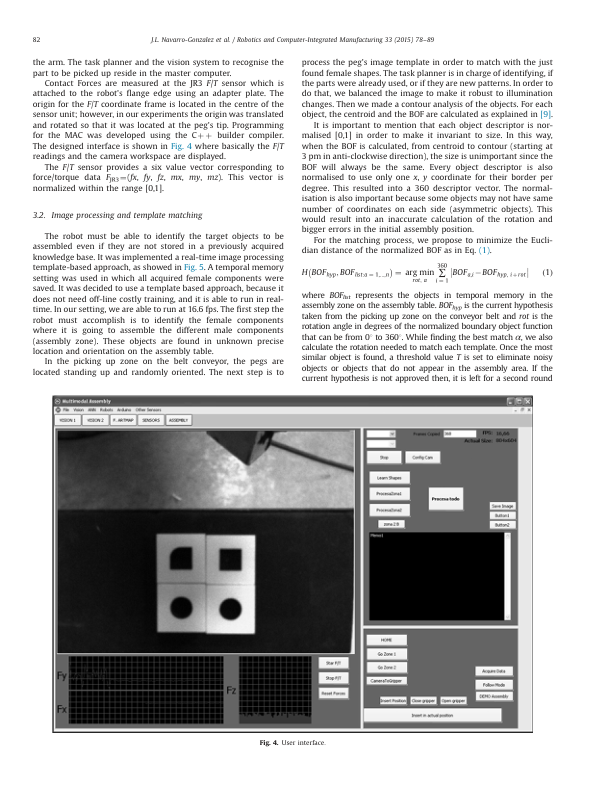

LLM query took 29.843896627426147 seconds to process!
(" The image you've provided is from a research paper discussing the concept "
 'of robotic assembly and its importance in modern manufacturing. Some '
 'important aspects of robotic assembly that the paper likely addresses are:\n'
 '\n'
 '1. **Efficiency**: Robots can perform tasks at a much faster pace than '
 'humans, which increases overall productivity and efficiency.\n'
 '\n'
 '2. **Consistency**: Robots are highly consistent, ensuring that each product '
 'is assembled to exact specifications with little to no variance in the '
 'quality of assembly.\n'
 '\n'
 '3. **Safety**: In many industries, robotic assembly can help eliminate '
 'workplace injuries by performing tasks that are dangerous or repetitive for '
 'humans.\n'
 '\n'
 '4. **Quality Control**: Robots can perform precise measurements and actions, '
 'which improves quality control in the manufacturing process.\n'
 '\n'
 '5. **Cost Savings**: Although there may be i

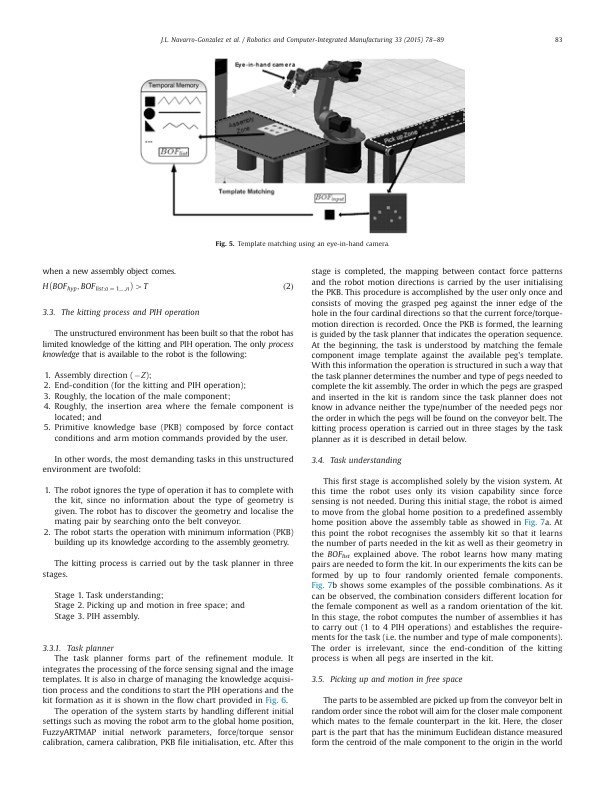

LLM query took 27.67625665664673 seconds to process!
(' The image shows a page from a scientific paper or article, discussing the '
 'topic of robotic assembly. While I cannot provide specific details without '
 'seeing the text, I can highlight some general important aspects of robotic '
 'assembly:\n'
 '\n'
 '1. **Precision and Repeatability**: Robots are often used for tasks that '
 'require high precision and repeatability, such as in manufacturing or '
 'electronics assembly.\n'
 '\n'
 '2. **Speed and Efficiency**: Robots can work much faster than humans, which '
 'can lead to significant efficiency gains in production lines.\n'
 '\n'
 '3. **Safety**: By automating repetitive and potentially dangerous tasks, '
 'robots can help ensure worker safety.\n'
 '\n'
 '4. **Consistency**: Robotic assembly ensures consistent product quality by '
 'following a programmed sequence of actions without deviation.\n'
 '\n'
 '5. **Ease of Programming**: Modern robotic systems are often programmabl

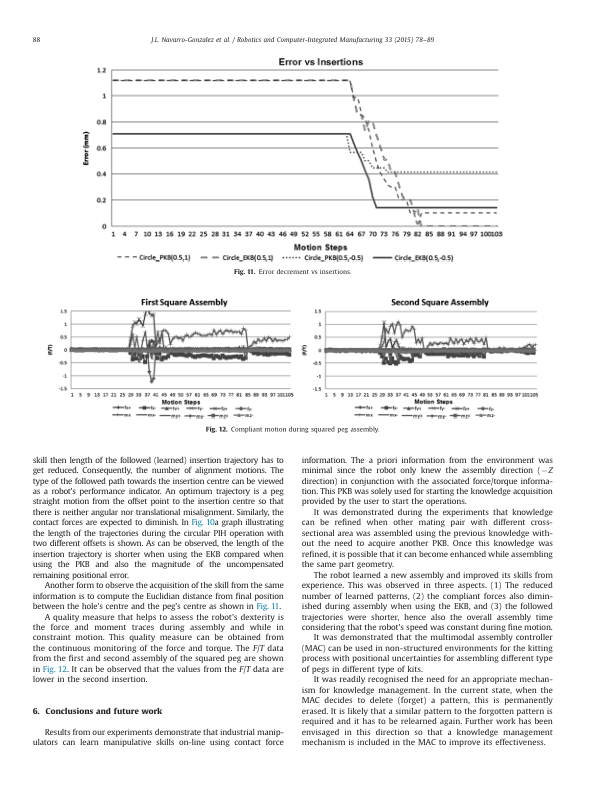

LLM query took 42.825244426727295 seconds to process!
(" The image you've provided appears to be a page from a scholarly paper or "
 'article discussing robotic assembly. While I cannot see the specific content '
 'of the document, I can provide some general aspects that are typically '
 'considered important in robotic assembly:\n'
 '\n'
 '1. **Automation**: Robotic systems aim to automate tasks that are '
 'repetitive, labor-intensive, or require precision and consistency. The '
 'efficiency of these systems can significantly reduce human intervention, '
 'save time, and lower operational costs.\n'
 '\n'
 '2. **Safety**: Ensuring that robotic assembly processes do not pose safety '
 'risks to operators and the surrounding environment is crucial. This includes '
 'adherence to safety protocols, safe operation within defined boundaries, and '
 'emergency response plans in case of malfunctions or errors.\n'
 '\n'
 '3. **Accuracy**: Robots need to be able to precisely execute tasks, such

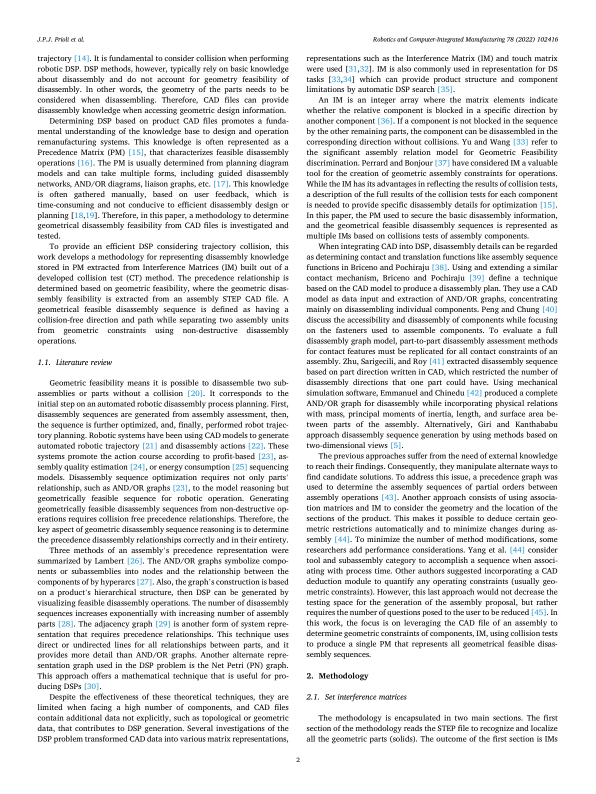

LLM query took 28.079854488372803 seconds to process!
(' The image shows a page from an academic paper or article, which discusses '
 'important aspects of robotic assembly. The highlighted sections in the text '
 'include:\n'
 '\n'
 '1. **Integration and Adaptability**: This likely refers to the ability of '
 'robots to integrate with existing manufacturing systems and adapt to '
 'different tasks within an assembly process.\n'
 '\n'
 '2. **Flexibility**: The paper mentions the need for flexibility, suggesting '
 'that robotic assemblies should be able to adjust to various production '
 'scenarios.\n'
 '\n'
 '3. **Cost-Effectiveness**: Another highlighted point is cost-effectiveness. '
 'This implies that robotic assembly systems should provide economic benefits '
 'by reducing labor costs or increasing efficiency in manufacturing.\n'
 '\n'
 '4. **Quality and Precision**: The paper emphasizes the importance of '
 'maintaining high quality standards and ensuring precise handling of '
 

In [29]:
deep_doc_ask( "What are the important aspects of robotic assembly?" )